In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
df_trees = pd.read_csv('data/trees_training.csv')

df_trees.loc[df_trees['scaler'].isna(), 'scaler'] = 'None'

C:\Users\ondre\AppData\Local\Temp\ipykernel_23640\3669827430.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trees = pd.read_csv('data/trees_training.csv')


In [107]:
df_xbg_best = pd.read_csv('data/xgb_acc_best.csv')
df_ada_best = pd.read_csv('data/ada_acc_best.csv')
df_xgb_compound_best = pd.read_csv('data/xgb_compund_best.csv')
df_ada_compund_best = pd.read_csv('data/ada_compund_best.csv')

In [108]:
df_temp = pd.read_csv('data/general_training1.csv')
df1_temp = pd.read_csv('data/general_training2.csv')

In [109]:
df_general = pd.concat([df_temp, df1_temp], ignore_index=True)

In [110]:
condition = (df_general['model'] == 'XGBoost') | (df_general['model'] == 'LinearRegression')
df_general.loc[condition, 'depth'] = 0

## General Training Overview

In this study, I evaluated and compared **four different models** for the binary classification task of predicting stock market movement (up/down):

- **LSTM** and **Transformer**  
  - Total of **24 runs**  
  - Hyperparameter: network depth ranged from **2 to 21**

- **XGBoost** and **Linear Regression**  
  - Total of **147 runs**  
  - No hyperparameter tuning applied

The **initial hypothesis** was that the LSTM and Transformer models—due to their sequence modeling capabilities—would be **best suited** for capturing the temporal dynamics of financial data.


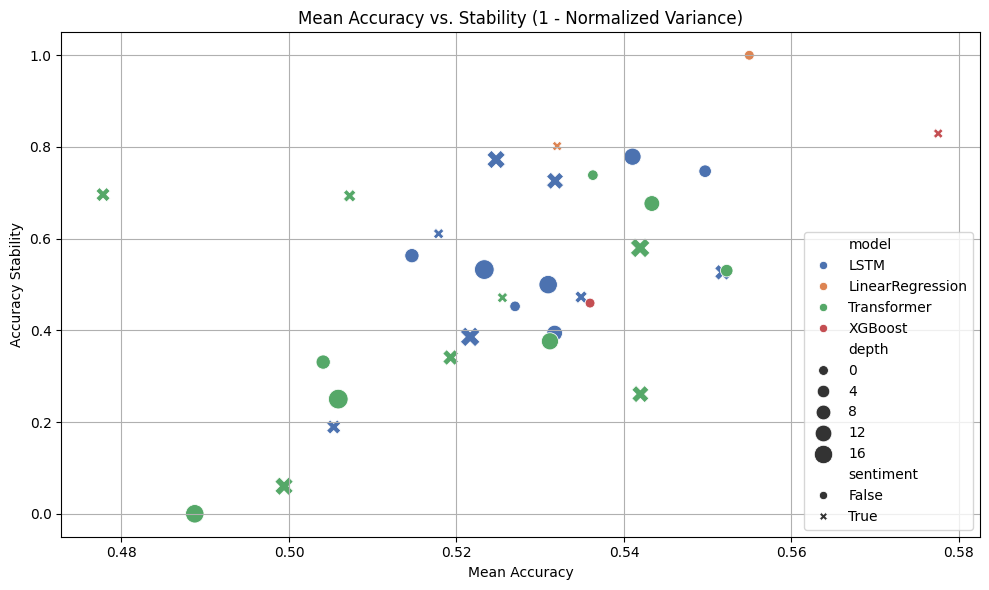

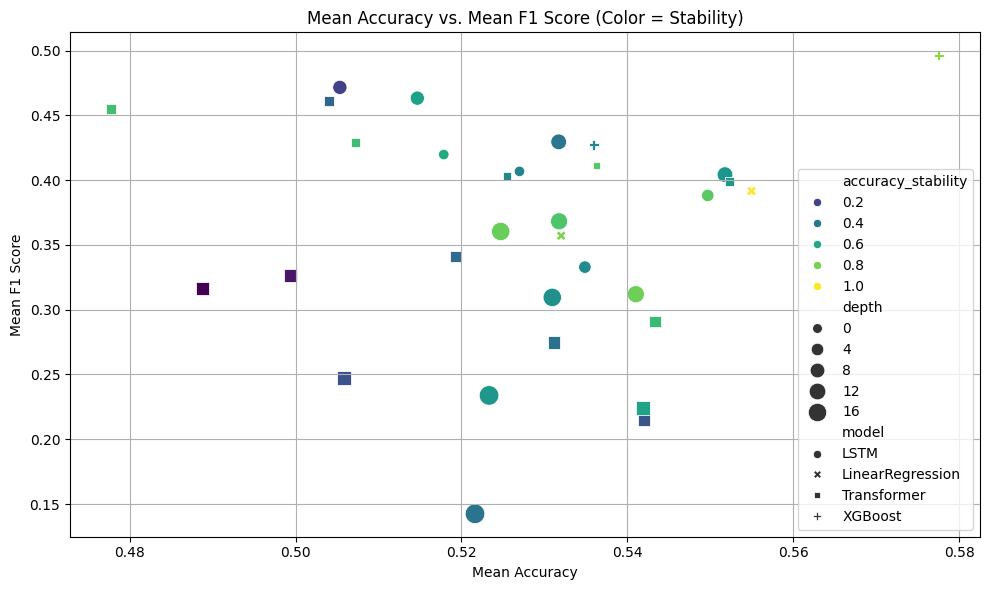

In [111]:
df = df_general

# Calculate mean and variance, then convert variance to a "stability" score
group_cols = ["model", "depth", "sentiment", "lag"]  # Add others like "scaler" or "run" if needed

grouped = df.groupby(group_cols).agg(
    accuracy_mean=("accuracy", "mean"),
    accuracy_var=("accuracy", "var"),
    f1_mean=("f1_score", "mean"),
    count=("accuracy", "count")
).reset_index()

# Keep only groups with enough data points
grouped = grouped[grouped["count"] >= 2]

# Rescale variance to 'stability' (1 - normalized variance)
# Normalize variance first to range [0, 1]
var_min = grouped["accuracy_var"].min()
var_max = grouped["accuracy_var"].max()
grouped["accuracy_stability"] = 1 - (grouped["accuracy_var"] - var_min) / (var_max - var_min + 1e-8)

# --- Plot: Mean Accuracy vs. Stability ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    x="accuracy_mean",
    y="accuracy_stability",
    hue="model",
    style="sentiment",
    size="depth",
    sizes=(50, 200),
    palette="deep"
)
plt.title("Mean Accuracy vs. Stability (1 - Normalized Variance)")
plt.xlabel("Mean Accuracy")
plt.ylabel("Accuracy Stability")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Accuracy vs F1 Score with Stability Coloring ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    x="accuracy_mean",
    y="f1_mean",
    hue="accuracy_stability",
    size="depth",
    style="model",
    palette="viridis",
    sizes=(50, 200)
)
plt.title("Mean Accuracy vs. Mean F1 Score (Color = Stability)")
plt.xlabel("Mean Accuracy")
plt.ylabel("Mean F1 Score")
plt.grid(True)
plt.tight_layout()
plt.show()



In [112]:
grouped.sort_values(by='accuracy_mean', ascending=False).head(10)

,model,depth,sentiment,lag,accuracy_mean,accuracy_var,f1_mean,count,accuracy_stability
31,XGBoost,0,True,5,0.577524,0.003083,0.496474,147,0.829346
14,LinearRegression,0,False,5,0.554966,0.001452,0.391613,147,1.000000
18,Transformer,4,False,5,0.552270,0.005940,0.398949,24,0.530293
7,LSTM,10,True,5,0.551770,0.005975,0.404297,24,0.526591
2,LSTM,4,False,5,0.549690,0.003868,0.388227,24,0.747165
22,Transformer,10,False,5,0.543330,0.004541,0.290733,24,0.676665
25,Transformer,13,True,5,0.541957,0.008513,0.215034,24,0.260999
29,Transformer,19,True,5,0.541931,0.005467,0.224123,15,0.579827
8,LSTM,13,False,5,0.541021,0.003566,0.311988,24,0.778785
16,Transformer,1,False,5,0.536288,0.003950,0.411352,24,0.738536


### Why XGBoost with Sentiment Features is a Strong Candidate

XGBoost enhanced with sentiment features **significantly outperformed** all other models, achieving approximately **2.2% higher accuracy**.

It also achieved the **highest F1 score**, indicating strong balance between precision and recall—crucial in imbalanced or noisy financial data.

Additionally, it ranked **second-best in accuracy variance**, which is important in this context—demonstrating both **strong performance** and **consistency** across different conditions.

These three factors combined make it an **optimal candidate for further investigation**.


## Detailed Training Results: AdaBoost and XGBoost

Since **XGBoost performed the best** among the four evaluated models, I conducted a more detailed analysis of **AdaBoost** and **XGBoost**.

A new metric, called the **compound score**, was introduced.  
It is defined as the **sum of the normalized (min-max scaled)** mean accuracy and F1 score, computed across all runs that share the same hyperparameters.  
This score offers a balanced view of both precision and robustness.

---

### Key Observations

- **Surprisingly**, the highest **mean accuracy** for XGBoost was achieved **without** using sentiment features.
- Similarly, the models with the **best compound scores**—for both AdaBoost and XGBoost—**did not use sentiment features**.
- This suggests that **sentiment data** might need to be **modeled differently** to become a more useful feature in training.

---

### Importance of Accuracy Variance

An important additional dimension is the **variance in accuracy** across runs with the **same hyperparameters**.  
In real-world deployment, **stability** is critical:  
> A model with an average accuracy of 59% is far less desirable if its performance varies widely—say from **49% to 69%**—compared to a more consistent model.

Lower variance means more **predictable and reliable** behavior, which is crucial in high-stakes environments like trading.

---

### Next: Tables and Graphs

The following tables and plots illustrate and compare:
- Mean accuracy and F1 scores
- Compound scores
- Accuracy variance  
...across different model configurations and feature sets.


In [113]:
from sklearn.preprocessing import MinMaxScaler

cols_xgb = ['model',
 #'ticker',
 'scaler',
 'sentiment',
 'lag',
 'technical_indicators',
 'xgb_max_depth',
 'xgb_min_child_weight',
 'xgb_gamma',
 'learning_rate',
 'n_estimators',]
 #'base_estimator_max_depth']

df_xgb = df_trees.copy()
df_xgb.drop(columns=['base_estimator_max_depth'], inplace=True, errors='ignore')

xgb_grouped = df_xgb.groupby(cols_xgb).agg(
    accuracy_mean=('accuracy', 'mean'),
    accuracy_var=('accuracy', 'var'),
    f1_mean=('f1_score', 'mean') if 'f1_score' in df_xgb.columns else ('accuracy', 'mean'),
    count=('accuracy', 'count')
).reset_index()

display(xgb_grouped.sort_values(by='accuracy_mean', ascending=False).head(10))
display(xgb_grouped.sort_values(by='f1_mean', ascending=False).head(10))

scaler = MinMaxScaler()
scaler.fit(xgb_grouped[['accuracy_mean']])
xgb_grouped['accuracy_mean_scaled'] = scaler.transform(xgb_grouped[['accuracy_mean']])

scaler.fit(xgb_grouped[['f1_mean']])
xgb_grouped['f1_mean_scaled'] = scaler.transform(xgb_grouped[['f1_mean']])


xgb_grouped['compound_score'] = xgb_grouped['accuracy_mean_scaled'] * 0.5 + xgb_grouped['f1_mean_scaled'] * 0.5
display(xgb_grouped.sort_values(by='compound_score', ascending=False).head(10))

,model,scaler,sentiment,lag,technical_indicators,xgb_max_depth,xgb_min_child_weight,xgb_gamma,learning_rate,n_estimators,accuracy_mean,accuracy_var,f1_mean,count
893,XGBoost,standard,False,10,True,5.0,3.0,0.2,0.05,150,0.589056,0.004531,0.485335,24
509,XGBoost,minmax,False,10,True,5.0,3.0,0.2,0.05,150,0.589056,0.004531,0.485335,24
125,XGBoost,None,False,10,True,5.0,3.0,0.2,0.05,150,0.589056,0.004531,0.485335,24
486,XGBoost,minmax,False,10,True,3.0,1.0,0.2,0.10,100,0.582520,0.002693,0.509189,24
487,XGBoost,minmax,False,10,True,3.0,1.0,0.2,0.10,150,0.582520,0.002693,0.507431,24
870,XGBoost,standard,False,10,True,3.0,1.0,0.2,0.10,100,0.582520,0.002693,0.509189,24
871,XGBoost,standard,False,10,True,3.0,1.0,0.2,0.10,150,0.582520,0.002693,0.507431,24
102,XGBoost,None,False,10,True,3.0,1.0,0.2,0.10,100,0.582520,0.002693,0.509189,24
103,XGBoost,None,False,10,True,3.0,1.0,0.2,0.10,150,0.582520,0.002693,0.507431,24
630,XGBoost,minmax,True,5,True,5.0,1.0,0.2,0.10,100,0.576000,0.004262,0.459314,24


,model,scaler,sentiment,lag,technical_indicators,xgb_max_depth,xgb_min_child_weight,xgb_gamma,learning_rate,n_estimators,accuracy_mean,accuracy_var,f1_mean,count
69,XGBoost,None,False,10,False,3.0,1.0,0.2,0.05,150,0.536543,0.002623,0.605056,24
453,XGBoost,minmax,False,10,False,3.0,1.0,0.2,0.05,150,0.536543,0.002623,0.605056,24
837,XGBoost,standard,False,10,False,3.0,1.0,0.2,0.05,150,0.536543,0.002623,0.605056,24
775,XGBoost,standard,False,5,False,3.0,1.0,0.2,0.10,150,0.564957,0.002523,0.600084,24
391,XGBoost,minmax,False,5,False,3.0,1.0,0.2,0.10,150,0.564957,0.002523,0.600084,24
7,XGBoost,None,False,5,False,3.0,1.0,0.2,0.10,150,0.564957,0.002523,0.600084,24
833,XGBoost,standard,False,10,False,3.0,1.0,0.0,0.05,150,0.529444,0.002379,0.597341,24
449,XGBoost,minmax,False,10,False,3.0,1.0,0.0,0.05,150,0.529444,0.002379,0.597341,24
65,XGBoost,None,False,10,False,3.0,1.0,0.0,0.05,150,0.529444,0.002379,0.597341,24
452,XGBoost,minmax,False,10,False,3.0,1.0,0.2,0.05,100,0.535170,0.002724,0.595617,24


,model,scaler,sentiment,lag,technical_indicators,xgb_max_depth,xgb_min_child_weight,xgb_gamma,learning_rate,n_estimators,accuracy_mean,accuracy_var,f1_mean,count,accuracy_mean_scaled,f1_mean_scaled,compound_score
775,XGBoost,standard,False,5,False,3.0,1.0,0.2,0.10,150,0.564957,0.002523,0.600084,24,0.775083,0.980313,0.877698
7,XGBoost,None,False,5,False,3.0,1.0,0.2,0.10,150,0.564957,0.002523,0.600084,24,0.775083,0.980313,0.877698
391,XGBoost,minmax,False,5,False,3.0,1.0,0.2,0.10,150,0.564957,0.002523,0.600084,24,0.775083,0.980313,0.877698
390,XGBoost,minmax,False,5,False,3.0,1.0,0.2,0.10,100,0.550305,0.000579,0.591199,24,0.638340,0.945133,0.791736
774,XGBoost,standard,False,5,False,3.0,1.0,0.2,0.10,100,0.550305,0.000579,0.591199,24,0.638340,0.945133,0.791736
6,XGBoost,None,False,5,False,3.0,1.0,0.2,0.10,100,0.550305,0.000579,0.591199,24,0.638340,0.945133,0.791736
385,XGBoost,minmax,False,5,False,3.0,1.0,0.0,0.05,150,0.549141,0.000649,0.592338,24,0.627477,0.949644,0.788561
769,XGBoost,standard,False,5,False,3.0,1.0,0.0,0.05,150,0.549141,0.000649,0.592338,24,0.627477,0.949644,0.788561
1,XGBoost,None,False,5,False,3.0,1.0,0.0,0.05,150,0.549141,0.000649,0.592338,24,0.627477,0.949644,0.788561
3,XGBoost,None,False,5,False,3.0,1.0,0.0,0.10,150,0.551340,0.001326,0.584546,24,0.647998,0.918792,0.783395


In [114]:
cols_ada = ['model',
 #'ticker',
 'scaler',
 'sentiment',
 'lag',
 'technical_indicators',
 'learning_rate',
 'n_estimators',
 'base_estimator_max_depth']

df_ada = df_trees.copy()
df_ada.drop(columns=['xgb_max_depth','xgb_min_child_weight','xgb_gamma'], inplace=True, errors='ignore')

ada_grouped = df_ada.groupby(cols_ada).agg(
    accuracy_mean=('accuracy', 'mean'),
    accuracy_var=('accuracy', 'var'),
    f1_mean=('f1_score', 'mean') if 'f1_score' in df_ada.columns else ('accuracy', 'mean'),
    count=('accuracy', 'count')
).reset_index()

display(ada_grouped.sort_values(by='accuracy_mean', ascending=False).head(10))
display(ada_grouped.sort_values(by='f1_mean', ascending=False).head(10))
display(ada_grouped.sort_values(by='accuracy_var', ascending=True).head(10))

scaler = MinMaxScaler()
scaler.fit(ada_grouped[['accuracy_mean']])
ada_grouped['accuracy_mean_scaled'] = scaler.transform(ada_grouped[['accuracy_mean']])

scaler.fit(ada_grouped[['f1_mean']])
ada_grouped['f1_mean_scaled'] = scaler.transform(ada_grouped[['f1_mean']])


ada_grouped['compound_score'] = ada_grouped['accuracy_mean_scaled'] * 0.5 + ada_grouped['f1_mean_scaled'] * 0.5
display(ada_grouped.sort_values(by='compound_score', ascending=False).head(10))

,model,scaler,sentiment,lag,technical_indicators,learning_rate,n_estimators,base_estimator_max_depth,accuracy_mean,accuracy_var,f1_mean,count
501,AdaBoost,standard,True,5,True,0.5,100,3.0,0.594507,0.005110,0.481020,24
309,AdaBoost,minmax,True,5,True,0.5,100,3.0,0.590113,0.005345,0.469740,24
20,AdaBoost,None,False,5,True,0.5,100,1.0,0.578608,0.007952,0.476022,24
503,AdaBoost,standard,True,5,True,0.5,100,5.0,0.577807,0.004025,0.461301,24
212,AdaBoost,minmax,False,5,True,0.5,100,1.0,0.577639,0.008016,0.471462,24
404,AdaBoost,standard,False,5,True,0.5,100,1.0,0.577512,0.007679,0.476582,24
216,AdaBoost,minmax,False,5,True,1.0,50,1.0,0.577490,0.007314,0.461942,24
408,AdaBoost,standard,False,5,True,1.0,50,1.0,0.574583,0.007352,0.448860,24
24,AdaBoost,None,False,5,True,1.0,50,1.0,0.574583,0.007352,0.448860,24
125,AdaBoost,None,True,5,True,1.0,100,3.0,0.573579,0.005197,0.484203,24


,model,scaler,sentiment,lag,technical_indicators,learning_rate,n_estimators,base_estimator_max_depth,accuracy_mean,accuracy_var,f1_mean,count
47,AdaBoost,None,False,10,False,1.0,100,5.0,0.549494,0.002792,0.602786,24
431,AdaBoost,standard,False,10,False,1.0,100,5.0,0.554228,0.003719,0.597540,24
43,AdaBoost,None,False,10,False,1.0,50,5.0,0.563362,0.003331,0.597261,24
4,AdaBoost,None,False,5,False,0.5,100,1.0,0.540728,0.002558,0.596537,24
196,AdaBoost,minmax,False,5,False,0.5,100,1.0,0.540255,0.002529,0.594375,24
388,AdaBoost,standard,False,5,False,0.5,100,1.0,0.537346,0.002334,0.590760,24
233,AdaBoost,minmax,False,10,False,1.0,50,3.0,0.544341,0.003279,0.589585,24
231,AdaBoost,minmax,False,10,False,0.5,100,5.0,0.539707,0.001849,0.588690,24
425,AdaBoost,standard,False,10,False,1.0,50,3.0,0.538183,0.002208,0.588583,24
41,AdaBoost,None,False,10,False,1.0,50,3.0,0.536904,0.002218,0.588133,24


,model,scaler,sentiment,lag,technical_indicators,learning_rate,n_estimators,base_estimator_max_depth,accuracy_mean,accuracy_var,f1_mean,count
268,AdaBoost,minmax,False,15,False,1.0,100,1.0,0.480039,0.000962,0.498771,24
364,AdaBoost,minmax,True,15,False,1.0,100,1.0,0.509675,0.000981,0.496684,24
556,AdaBoost,standard,True,15,False,1.0,100,1.0,0.509675,0.000981,0.496684,24
6,AdaBoost,None,False,5,False,0.5,100,4.0,0.542495,0.000992,0.547269,24
455,AdaBoost,standard,False,15,False,0.5,100,5.0,0.521423,0.000997,0.554038,24
172,AdaBoost,None,True,15,False,1.0,100,1.0,0.509044,0.001004,0.495901,24
67,AdaBoost,None,False,15,False,0.5,50,5.0,0.522914,0.001014,0.544757,24
517,AdaBoost,standard,True,10,False,0.5,100,3.0,0.509632,0.001038,0.526801,24
198,AdaBoost,minmax,False,5,False,0.5,100,4.0,0.545527,0.001110,0.553993,24
515,AdaBoost,standard,True,10,False,0.5,50,5.0,0.503448,0.001117,0.498625,24


,model,scaler,sentiment,lag,technical_indicators,learning_rate,n_estimators,base_estimator_max_depth,accuracy_mean,accuracy_var,f1_mean,count,accuracy_mean_scaled,f1_mean_scaled,compound_score
43,AdaBoost,None,False,10,False,1.0,50,5.0,0.563362,0.003331,0.597261,24,0.731765,0.976566,0.854165
431,AdaBoost,standard,False,10,False,1.0,100,5.0,0.554228,0.003719,0.597540,24,0.653101,0.977752,0.815426
47,AdaBoost,None,False,10,False,1.0,100,5.0,0.549494,0.002792,0.602786,24,0.612335,1.000000,0.806167
239,AdaBoost,minmax,False,10,False,1.0,100,5.0,0.553549,0.002017,0.587728,24,0.647252,0.936131,0.791691
233,AdaBoost,minmax,False,10,False,1.0,50,3.0,0.544341,0.003279,0.589585,24,0.567953,0.944009,0.755981
4,AdaBoost,None,False,5,False,0.5,100,1.0,0.540728,0.002558,0.596537,24,0.536833,0.973494,0.755163
423,AdaBoost,standard,False,10,False,0.5,100,5.0,0.547180,0.002311,0.583323,24,0.592405,0.917449,0.754927
196,AdaBoost,minmax,False,5,False,0.5,100,1.0,0.540255,0.002529,0.594375,24,0.532763,0.964325,0.748544
501,AdaBoost,standard,True,5,True,0.5,100,3.0,0.594507,0.005110,0.481020,24,1.000000,0.483520,0.741760
430,AdaBoost,standard,False,10,False,1.0,100,4.0,0.549035,0.002575,0.572330,24,0.608379,0.870820,0.739599


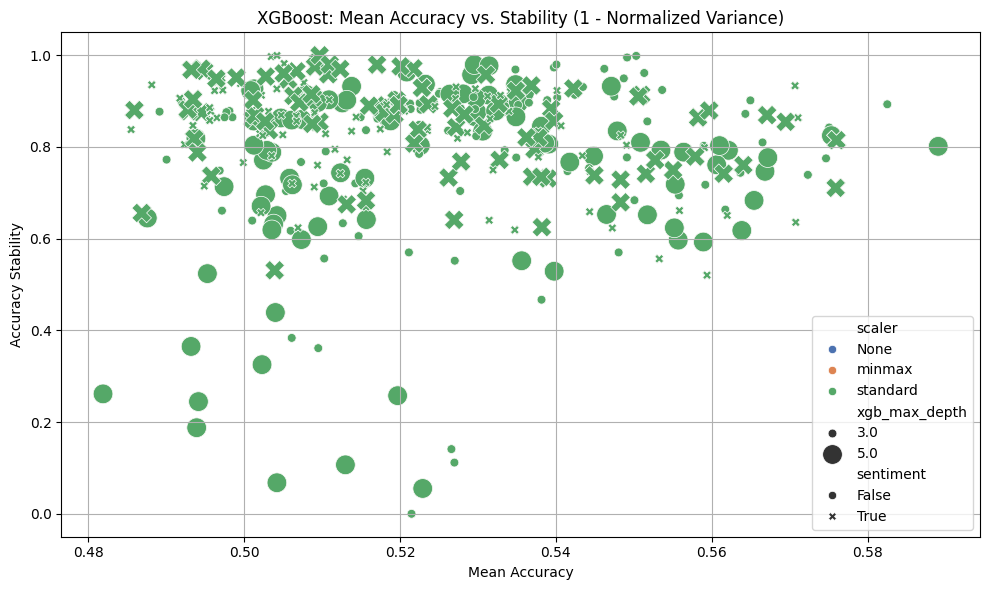

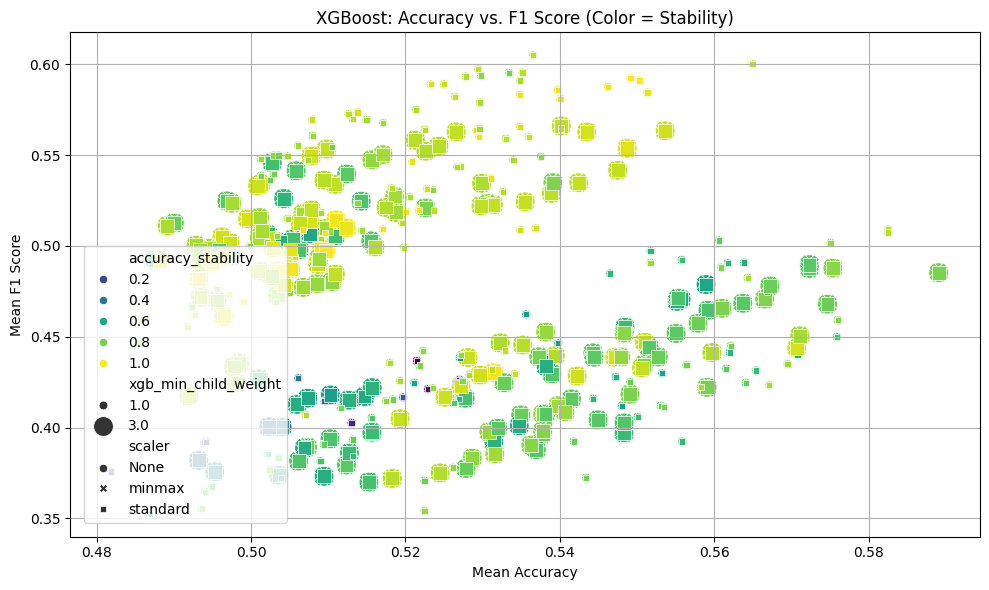

In [115]:
# --- Define grouping columns ---
cols_xgb = [
    'model',
    'scaler',
    'sentiment',
    'lag',
    'technical_indicators',
    'xgb_max_depth',
    'xgb_min_child_weight',
    'xgb_gamma',
    'learning_rate',
    'n_estimators'
]

# --- Prepare df_xgb (dropping unrelated column if present) ---
df_xgb = df_trees.copy()
df_xgb.drop(columns=['base_estimator_max_depth'], inplace=True, errors='ignore')

# --- Group and aggregate ---
grouped_xgb = df_xgb.groupby(cols_xgb).agg(
    accuracy_mean=('accuracy', 'mean'),
    accuracy_var=('accuracy', 'var'),
    f1_mean=('f1_score', 'mean') if 'f1_score' in df_xgb.columns else ('accuracy', 'mean'),
    count=('accuracy', 'count')
).reset_index()

# Keep only groups with at least 2 data points
grouped_xgb = grouped_xgb[grouped_xgb['count'] >= 2]

# --- Normalize variance and compute stability ---
var_min = grouped_xgb['accuracy_var'].min()
var_max = grouped_xgb['accuracy_var'].max()
grouped_xgb['accuracy_stability'] = 1 - (grouped_xgb['accuracy_var'] - var_min) / (var_max - var_min + 1e-8)

# --- Plot: Accuracy vs Stability ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped_xgb,
    x='accuracy_mean',
    y='accuracy_stability',
    hue='scaler',
    style='sentiment',
    size='xgb_max_depth',
    sizes=(40, 200),
    palette='deep'
)
plt.title('XGBoost: Mean Accuracy vs. Stability (1 - Normalized Variance)')
plt.xlabel('Mean Accuracy')
plt.ylabel('Accuracy Stability')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Accuracy vs. F1 Score with Hue = Stability ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped_xgb,
    x='accuracy_mean',
    y='f1_mean',
    hue='accuracy_stability',
    size='xgb_min_child_weight',
    style='scaler',
    palette='viridis',
    sizes=(40, 200)
)
plt.title('XGBoost: Accuracy vs. F1 Score (Color = Stability)')
plt.xlabel('Mean Accuracy')
plt.ylabel('Mean F1 Score')
plt.grid(True)

# Move legend to bottom left
plt.legend(
    bbox_to_anchor=(0, 0),  # bottom left corner of the axes
    loc='lower left',
    borderaxespad=1,
    frameon=True
)

plt.tight_layout()
plt.show()



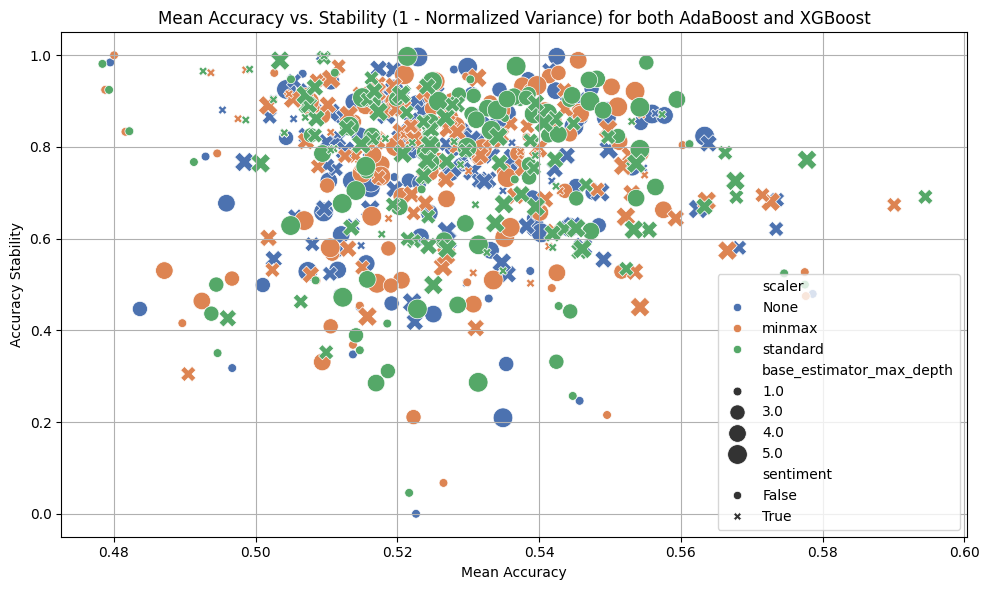

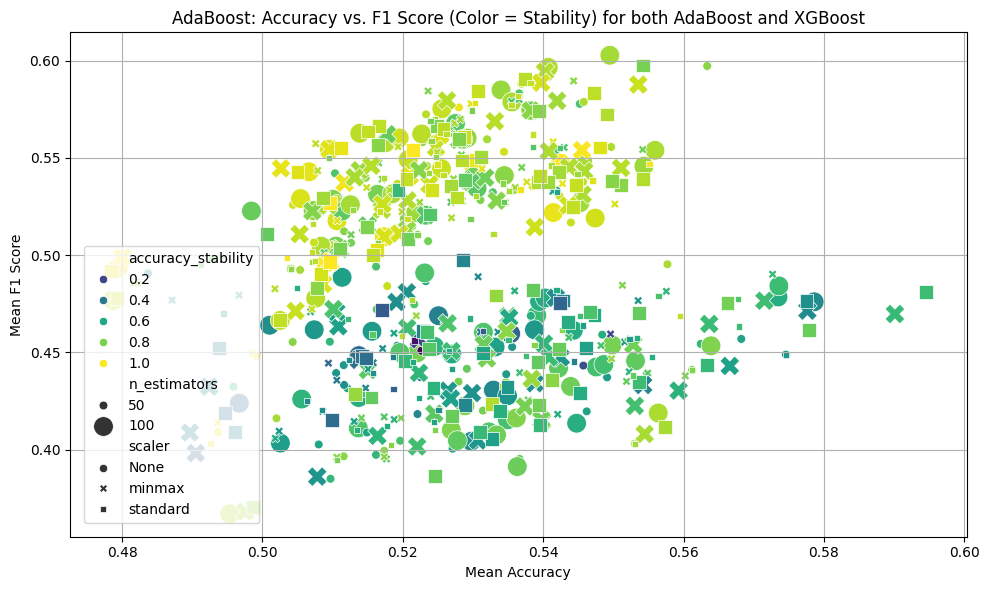

In [116]:
# --- Group and Aggregate ---
group_cols = [
    'model',
    'scaler',
    'sentiment',
    'lag',
    'technical_indicators',
    'learning_rate',
    'n_estimators',
    'base_estimator_max_depth'
]

grouped = df_ada.groupby(group_cols).agg(
    accuracy_mean=('accuracy', 'mean'),
    accuracy_var=('accuracy', 'var'),
    f1_mean=('f1_score', 'mean') if 'f1_score' in df_ada.columns else ('accuracy', 'mean'),
    count=('accuracy', 'count')
).reset_index()

# Filter groups with at least 2 runs for variance to be meaningful
grouped = grouped[grouped['count'] >= 2]

# --- Normalize variance and compute stability ---
var_min = grouped['accuracy_var'].min()
var_max = grouped['accuracy_var'].max()
grouped['accuracy_stability'] = 1 - (grouped['accuracy_var'] - var_min) / (var_max - var_min + 1e-8)

# --- First Plot: Accuracy vs. Stability ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    x='accuracy_mean',
    y='accuracy_stability',
    hue='scaler',
    style='sentiment',
    size='base_estimator_max_depth',
    sizes=(40, 200),
    palette='deep'
)
plt.title('Mean Accuracy vs. Stability (1 - Normalized Variance) for both AdaBoost and XGBoost')
plt.xlabel('Mean Accuracy')
plt.ylabel('Accuracy Stability')
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Accuracy vs. F1 Score with Hue = Stability ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    x='accuracy_mean',
    y='f1_mean',
    hue='accuracy_stability',
    size='n_estimators',
    style='scaler',
    palette='viridis',
    sizes=(40, 200)
)
plt.title('AdaBoost: Accuracy vs. F1 Score (Color = Stability) for both AdaBoost and XGBoost')
plt.xlabel('Mean Accuracy')
plt.ylabel('Mean F1 Score')
plt.grid(True)

# Move legend to bottom left
plt.legend(
    bbox_to_anchor=(0, 0),  # bottom left corner of the axes
    loc='lower left',
    borderaxespad=1,
    frameon=True
)

plt.tight_layout()
plt.show()



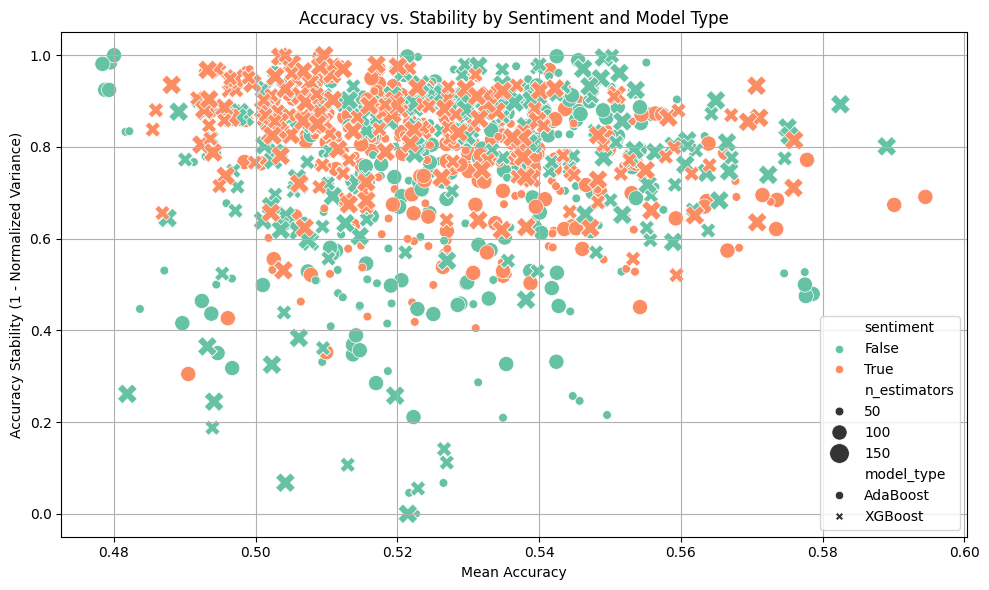

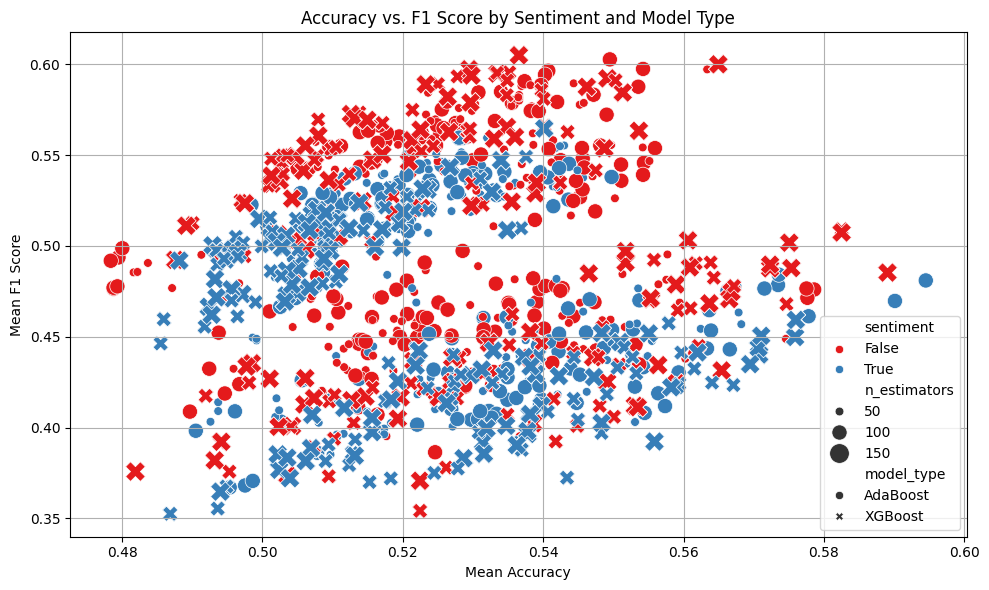

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- AdaBoost: Group and Aggregate ---
group_cols_ada = [
    'model',
    'scaler',
    'sentiment',
    'lag',
    'technical_indicators',
    'learning_rate',
    'n_estimators',
    'base_estimator_max_depth'
]

grouped_ada = df_ada.groupby(group_cols_ada).agg(
    accuracy_mean=('accuracy', 'mean'),
    accuracy_var=('accuracy', 'var'),
    f1_mean=('f1_score', 'mean') if 'f1_score' in df_ada.columns else ('accuracy', 'mean'),
    count=('accuracy', 'count')
).reset_index()

grouped_ada = grouped_ada[grouped_ada['count'] >= 2]
grouped_ada['accuracy_stability'] = 1 - (grouped_ada['accuracy_var'] - grouped_ada['accuracy_var'].min()) / (grouped_ada['accuracy_var'].max() - grouped_ada['accuracy_var'].min() + 1e-8)

grouped_ada = grouped_ada.rename(columns={
    'base_estimator_max_depth': 'model_depth'
})
grouped_ada['model_type'] = 'AdaBoost'

# --- XGBoost: Group and Aggregate ---
group_cols_xgb = [
    'model',
    'scaler',
    'sentiment',
    'lag',
    'technical_indicators',
    'xgb_max_depth',
    'xgb_min_child_weight',
    'xgb_gamma',
    'learning_rate',
    'n_estimators'
]

df_xgb = df_trees.copy()
df_xgb.drop(columns=['base_estimator_max_depth'], inplace=True, errors='ignore')

grouped_xgb = df_xgb.groupby(group_cols_xgb).agg(
    accuracy_mean=('accuracy', 'mean'),
    accuracy_var=('accuracy', 'var'),
    f1_mean=('f1_score', 'mean') if 'f1_score' in df_xgb.columns else ('accuracy', 'mean'),
    count=('accuracy', 'count')
).reset_index()

grouped_xgb = grouped_xgb[grouped_xgb['count'] >= 2]
grouped_xgb['accuracy_stability'] = 1 - (grouped_xgb['accuracy_var'] - grouped_xgb['accuracy_var'].min()) / (grouped_xgb['accuracy_var'].max() - grouped_xgb['accuracy_var'].min() + 1e-8)

grouped_xgb = grouped_xgb.rename(columns={
    'xgb_max_depth': 'model_depth'
})
grouped_xgb['model_type'] = 'XGBoost'

# --- Align Columns ---
common_cols = [
    'model',
    'scaler',
    'sentiment',
    'lag',
    'technical_indicators',
    'learning_rate',
    'n_estimators',
    'model_depth',
    'accuracy_mean',
    'accuracy_var',
    'f1_mean',
    'accuracy_stability',
    'count',
    'model_type'
]

grouped_combined = pd.concat([
    grouped_ada[common_cols],
    grouped_xgb[common_cols]
], ignore_index=True)

# --- Plot: Accuracy vs Stability (Hue = Sentiment) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped_combined,
    x='accuracy_mean',
    y='accuracy_stability',
    hue='sentiment',
    style='model_type',
    size='n_estimators',
    sizes=(40, 200),
    palette='Set2'
)
plt.title('Accuracy vs. Stability by Sentiment and Model Type')
plt.xlabel('Mean Accuracy')
plt.ylabel('Accuracy Stability (1 - Normalized Variance)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Accuracy vs. F1 Score (Hue = Sentiment) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped_combined,
    x='accuracy_mean',
    y='f1_mean',
    hue='sentiment',
    style='model_type',
    size='n_estimators',
    palette='Set1',
    sizes=(40, 200)
)
plt.title('Accuracy vs. F1 Score by Sentiment and Model Type')
plt.xlabel('Mean Accuracy')
plt.ylabel('Mean F1 Score')
plt.grid(True)
plt.tight_layout()
plt.show()



### Expected Profit by Model Strategy

Let’s now examine the **expected profit** if we were to follow the predictions of the following four model configurations:

- **AdaBoost** tuned for **highest accuracy**
- **AdaBoost** tuned for **highest compound score**
- **XGBoost** tuned for **highest accuracy**
- **XGBoost** tuned for **highest compound score**

These results provide insight into how different optimization goals (accuracy vs. compound score) impact real-world profitability.


In [118]:
def display_info(df):
    from IPython.display import display, Markdown

    # Overall average profit
    display(Markdown("### 📈 Overall Average Profit"))
    display(df['profit'].mean())

    # Average profit per ticker
    display(Markdown("### 💹 Average Profit by Ticker"))
    display(df.groupby('ticker')['profit'].mean())

    # Average accuracy per ticker
    display(Markdown("### 🎯 Average Accuracy by Ticker"))
    display(df.groupby('ticker')['accuracy'].mean())

    # Overall average accuracy
    display(Markdown("### ✅ Overall Average Accuracy"))
    display(df['accuracy'].mean())


In [119]:
display_info(df_xbg_best)

### 📈 Overall Average Profit

694.9982023239119

### 💹 Average Profit by Ticker

ticker
AAPL     900.426926
AMD    -2414.952545
AMZN    1347.080826
GOOG    1421.888069
META    2313.818909
MSFT    -170.045273
PG       744.610260
TSLA    1417.158447
Name: profit, dtype: float64

### 🎯 Average Accuracy by Ticker

ticker
AAPL    0.558140
AMD     0.534884
AMZN    0.581395
GOOG    0.651163
META    0.581395
MSFT    0.465116
PG      0.488372
TSLA    0.604651
Name: accuracy, dtype: float64

### ✅ Overall Average Accuracy

0.558139534883721

In [120]:
display_info(df_ada_best)

### 📈 Overall Average Profit

655.9122743225082

### 💹 Average Profit by Ticker

ticker
AAPL     630.584116
AMD      200.601721
AMZN    1509.617207
GOOG    1603.611594
META     416.082147
MSFT    1316.287411
PG      -867.681076
TSLA     438.195074
Name: profit, dtype: float64

### 🎯 Average Accuracy by Ticker

ticker
AAPL    0.523953
AMD     0.640952
AMZN    0.566744
GOOG    0.674211
META    0.541212
MSFT    0.566047
PG      0.476977
TSLA    0.577907
Name: accuracy, dtype: float64

### ✅ Overall Average Accuracy

0.5710003669321295

In [121]:
display_info(df_xgb_compound_best)

### 📈 Overall Average Profit

1611.9196233749362

### 💹 Average Profit by Ticker

ticker
AAPL    2629.731201
AMD     -890.607513
AMZN    2131.264992
GOOG     529.929276
META    -116.134186
MSFT    1229.992432
PG       -51.212952
TSLA    7432.393738
Name: profit, dtype: float64

### 🎯 Average Accuracy by Ticker

ticker
AAPL    0.565789
AMD     0.513158
AMZN    0.578947
GOOG    0.592105
META    0.526316
MSFT    0.526316
PG      0.539474
TSLA    0.644737
Name: accuracy, dtype: float64

### ✅ Overall Average Accuracy

0.5608552631578947

In [122]:
display_info(df_ada_compund_best)

### 📈 Overall Average Profit

869.4700098947153

### 💹 Average Profit by Ticker

ticker
AAPL    1265.510301
AMD      -29.610378
AMZN    1741.010277
GOOG    2571.139082
META    -506.540604
MSFT    -323.066875
PG       238.674091
TSLA    1998.644185
Name: profit, dtype: float64

### 🎯 Average Accuracy by Ticker

ticker
AAPL    0.565867
AMD     0.530533
AMZN    0.516667
GOOG    0.583867
META    0.528133
MSFT    0.433067
PG      0.488267
TSLA    0.504400
Name: accuracy, dtype: float64

### ✅ Overall Average Accuracy

0.51885

### Model Performance Analysis

Although the models tuned for **compound score** did not achieve the highest **accuracy** on the test set, they **outperformed** those optimized purely for accuracy in terms of **expected profit**.

> 📈 **Profit is computed** by simulating a daily trading strategy:  
> At the start of each trading day, a **long** or **short** position is taken based on whether the model predicts the price will go **up** or **down**.

---

### Summary of Results (40 Trading Days)

| Model     | Optimized For     | Accuracy (%) | Expected Profit (%) |
|-----------|-------------------|--------------|----------------------|
| AdaBoost  | Accuracy           | 57.10        | 6.55                 |
| AdaBoost  | Compound Score     | 51.89        | 8.69                 |
| XGBoost   | Accuracy           | 55.81        | 6.95                 |
| XGBoost   | Compound Score     | 56.09        | 16.12                |

---

These results demonstrate that **higher accuracy does not always translate to higher profitability**.  
In fact, tuning models for compound score can lead to **significantly better trading outcomes**, even when their classification accuracy is slightly lower.
